In [1]:
from SliceNet import SliceNet
from netUtils import getSingleExample
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import random
import math

import warnings
warnings.filterwarnings('ignore')
import os
import tensorflow as tf

tf.logging.set_verbosity(tf.logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'}
TF_CPP_MIN_LOG_LEVEL=2

%load_ext autoreload
%autoreload 2

W0430 13:31:24.838282 140411970148096 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


1.13.1


Using TensorFlow backend.


importing hub
Instructions for updating:
Colocations handled automatically by placer.


W0430 13:32:13.524652 140411970148096 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/control_flow_ops.py:3632: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


In [5]:
net = SliceNet(classification=True, class_weights=[1.0,10,0.2])
weights_path = '/home/bmmidei/SliceCast/models/weights_epoch040.h5'

## Sample predictions on unseen wiki articles

In [6]:
dataPath = Path('/home/bmmidei/SliceCast/data/dev/hdf5')
files = [str(x) for x in dataPath.glob('**/*') if x.suffix=='.hdf5']

mask = random.sample(range(0,len(files)), 1)

# randomly select a file to test
test_file = [x for (i,x) in enumerate(files) if i in mask][0]

In [7]:
preds, labels = net.predict(test_file=test_file,
                    num_samples=8,
                    weights_path=weights_path)

Starting Testing
Loaded weights from disk


In [8]:
np.set_printoptions(suppress=True)

preds = np.argmax(preds, axis=2)
labels = np.argmax(labels, axis=2)

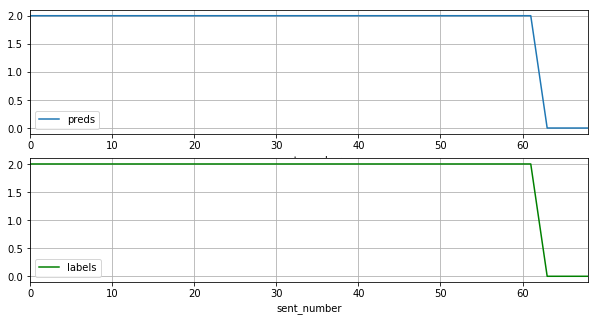

In [16]:
# Choose the document you want to examine
idx = 7


df = pd.DataFrame()
df['preds'] = preds[idx,:]
df['labels'] = labels[idx,:]
df['sent_number'] = df.index

fig, axes = plt.subplots(nrows=2, ncols=1)

df.plot(x='sent_number', y='preds', figsize=(10,5), grid=True, ax=axes[0])
df.plot(x='sent_number', y='labels', figsize=(10,5), grid=True, ax=axes[1], color='green')

## Sample predictions on unseen podcast data

In [17]:
test_file = '/home/bmmidei/SliceCast/data/podcasts/hdf5/batch0_0.hdf5'
weights_path = '/home/bmmidei/SliceCast/models/weights_epoch040.h5'

preds, labels = net.predict(test_file=test_file,
                    num_samples=8,
                    weights_path=weights_path)

Starting Testing
Loaded weights from disk


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7fb2e01cb908>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


In [18]:
np.set_printoptions(suppress=True)

preds = np.argmax(preds, axis=2)
labels = np.argmax(labels, axis=2)

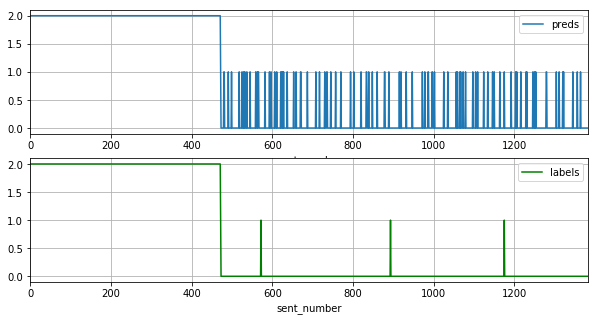

In [25]:
# Choose the document you want to examine
idx = 6

df = pd.DataFrame()
df['preds'] = preds[idx,:]
df['labels'] = labels[idx,:]
df['sent_number'] = df.index

fig, axes = plt.subplots(nrows=2, ncols=1)

df.plot(x='sent_number', y='preds', figsize=(10,5), grid=True, ax=axes[0])
df.plot(x='sent_number', y='labels', figsize=(10,5), grid=True, ax=axes[1], color='green')

## Predictions on a single text file

In [30]:
text_file = '/home/bmmidei/SliceCast/data/test/00/00/63/639'
is_labeled = True
weights_path = '/home/bmmidei/SliceCast/models/weights_epoch040.h5'

sents, labels = getSingleExample(fname=text_file, is_labeled=is_labeled)
sents = np.expand_dims(sents, axis=0)
print(sents.shape)
print(len(labels))
preds = net.singlePredict(sents, weights_path=weights_path)
print(preds.shape)

(1, 253)
253
Starting Testing
Loaded weights from disk


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7fb2b4098e48>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


(1, 253, 3)


In [31]:
# Place data into a pandas dataframe for analysis
df = pd.DataFrame()

preds = np.argmax(np.squeeze(preds), axis=-1)
df['raw_sentences'] = sents[0]
if is_labeled:
    df['labels'] = labels
df['preds'] = preds


In [32]:
df.head(50)

,raw_sentences,labels,preds
0,"In organic chemistry, an alkane, or paraffin (...",1,1
1,"In other words, an alkane consists of hydrogen...",0,0
2,Alkanes have the general chemical formula .,0,0
3,The alkanes range in complexity from the simpl...,0,0
4,Besides this standard definition by the Intern...,0,0
5,"In an alkane, each carbon atom has 4 bonds (ei...",0,1
6,The longest series of linked carbon atoms in a...,0,0
7,The number of carbon atoms may be thought of a...,0,0
8,"One group of the higher alkanes are waxes, sol...",0,0
9,"With their repeated -CH- units, the alkanes co...",0,0
